# 📦 Parcel Delivery Time Prediction
This project builds and compares machine learning models for predicting parcel delivery times using historical Amazon order data. The dataset was preprocessed with feature engineering (date-time transformations, distance calculations), as well as missing value handling, categorical encoding, and feature scaling.

* Four models were evaluated:
    * Random Forest
    * XGBoost
    * TensorFlow Deep Neural Network (DNN)
    * PyTorch Deep Neural Network (DNN)

# 🔍 Key Findings
* **Random Forest & XGBoost** achieved slightly better performance metrics (lower MAE and RMSE, higher R²) compared to TensorFlow DNN.
* **TensorFlow DNN** showed the **most stable learning curve**, with smooth convergence and better regularization, making it a strong candidate for generalization.
* **PyTorch DNN** displayed unstable training with error fluctuations and diverging validation error, suggesting poor convergence.

# 📊 Performance Metrics
* **Random Forest**: MAE = 17.05, RMSE = 22.10, R² = 0.81
* **XGBoost**: MAE = 17.32, RMSE = 22.30, R² = 0.81
* **TensorFlow DNN**: MAE = 17.91, RMSE = 23.17, R² = 0.80
* **PyTorch DNN**: less stable, weaker generalization

# ✅ Result
The **TensorFlow DNN** was selected as the final model due to its stability and strong generalization, while still achieving competitive MAE, RMSE, and R². A pipeline with preprocessing and model serialization was deployed for inference on new parcel orders.

In [2]:
!pip uninstall -y tensorflow tensorflow-gpu keras
!pip install tensorflow-cpu==2.18.0
!pip install keras==3.8.0

Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
Found existing installation: keras 3.8.0
Uninstalling keras-3.8.0:
  Successfully uninstalled keras-3.8.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.2/230.2 MB 7.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.1 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: keras
    Found existing installation: keras 3.12.0
    Uninstalling keras-3.12.0:
      Successfully uninstalled keras-3.12.0


In [4]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import missingno as msno
import random
import warnings

warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow import keras

import joblib

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/amazon-delivery-dataset/amazon_delivery.csv


# 1. Data Preprocessing
## Data cleaning

In [5]:
df = pd.read_csv('/kaggle/input/amazon-delivery-dataset/amazon_delivery.csv')

df.sample(3)

,Order_ID,Agent_Age,Agent_Rating,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,Order_Date,Order_Time,Pickup_Time,Weather,Traffic,Vehicle,Area,Delivery_Time,Category
32890,jikt120679994,31,4.8,22.753839,75.897429,22.773839,75.917429,2022-03-24,11:00:00,11:05:00,Sunny,Low,motorcycle,Metropolitian,95,Jewelry
21843,ovng097507066,20,4.7,11.003681,76.975525,11.073681,77.045525,2022-03-16,21:30:00,21:35:00,Sandstorms,Jam,scooter,Metropolitian,125,Clothing
20724,kkxj590551020,39,4.8,19.109300,72.825451,19.139300,72.855451,2022-03-05,23:50:00,00:05:00,Stormy,Low,motorcycle,Metropolitian,115,Toys


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43739 entries, 0 to 43738
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order_ID         43739 non-null  object 
 1   Agent_Age        43739 non-null  int64  
 2   Agent_Rating     43685 non-null  float64
 3   Store_Latitude   43739 non-null  float64
 4   Store_Longitude  43739 non-null  float64
 5   Drop_Latitude    43739 non-null  float64
 6   Drop_Longitude   43739 non-null  float64
 7   Order_Date       43739 non-null  object 
 8   Order_Time       43739 non-null  object 
 9   Pickup_Time      43739 non-null  object 
 10  Weather          43648 non-null  object 
 11  Traffic          43739 non-null  object 
 12  Vehicle          43739 non-null  object 
 13  Area             43739 non-null  object 
 14  Delivery_Time    43739 non-null  int64  
 15  Category         43739 non-null  object 
dtypes: float64(5), int64(2), object(9)
memory usage: 5.3+ MB


Order_ID           0.00
Agent_Age          0.00
Agent_Rating       0.12
Store_Latitude     0.00
Store_Longitude    0.00
Drop_Latitude      0.00
Drop_Longitude     0.00
Order_Date         0.00
Order_Time         0.00
Pickup_Time        0.00
Weather            0.21
Traffic            0.00
Vehicle            0.00
Area               0.00
Delivery_Time      0.00
Category           0.00
dtype: float64


<Axes: >


Number of duplicated rows: 0


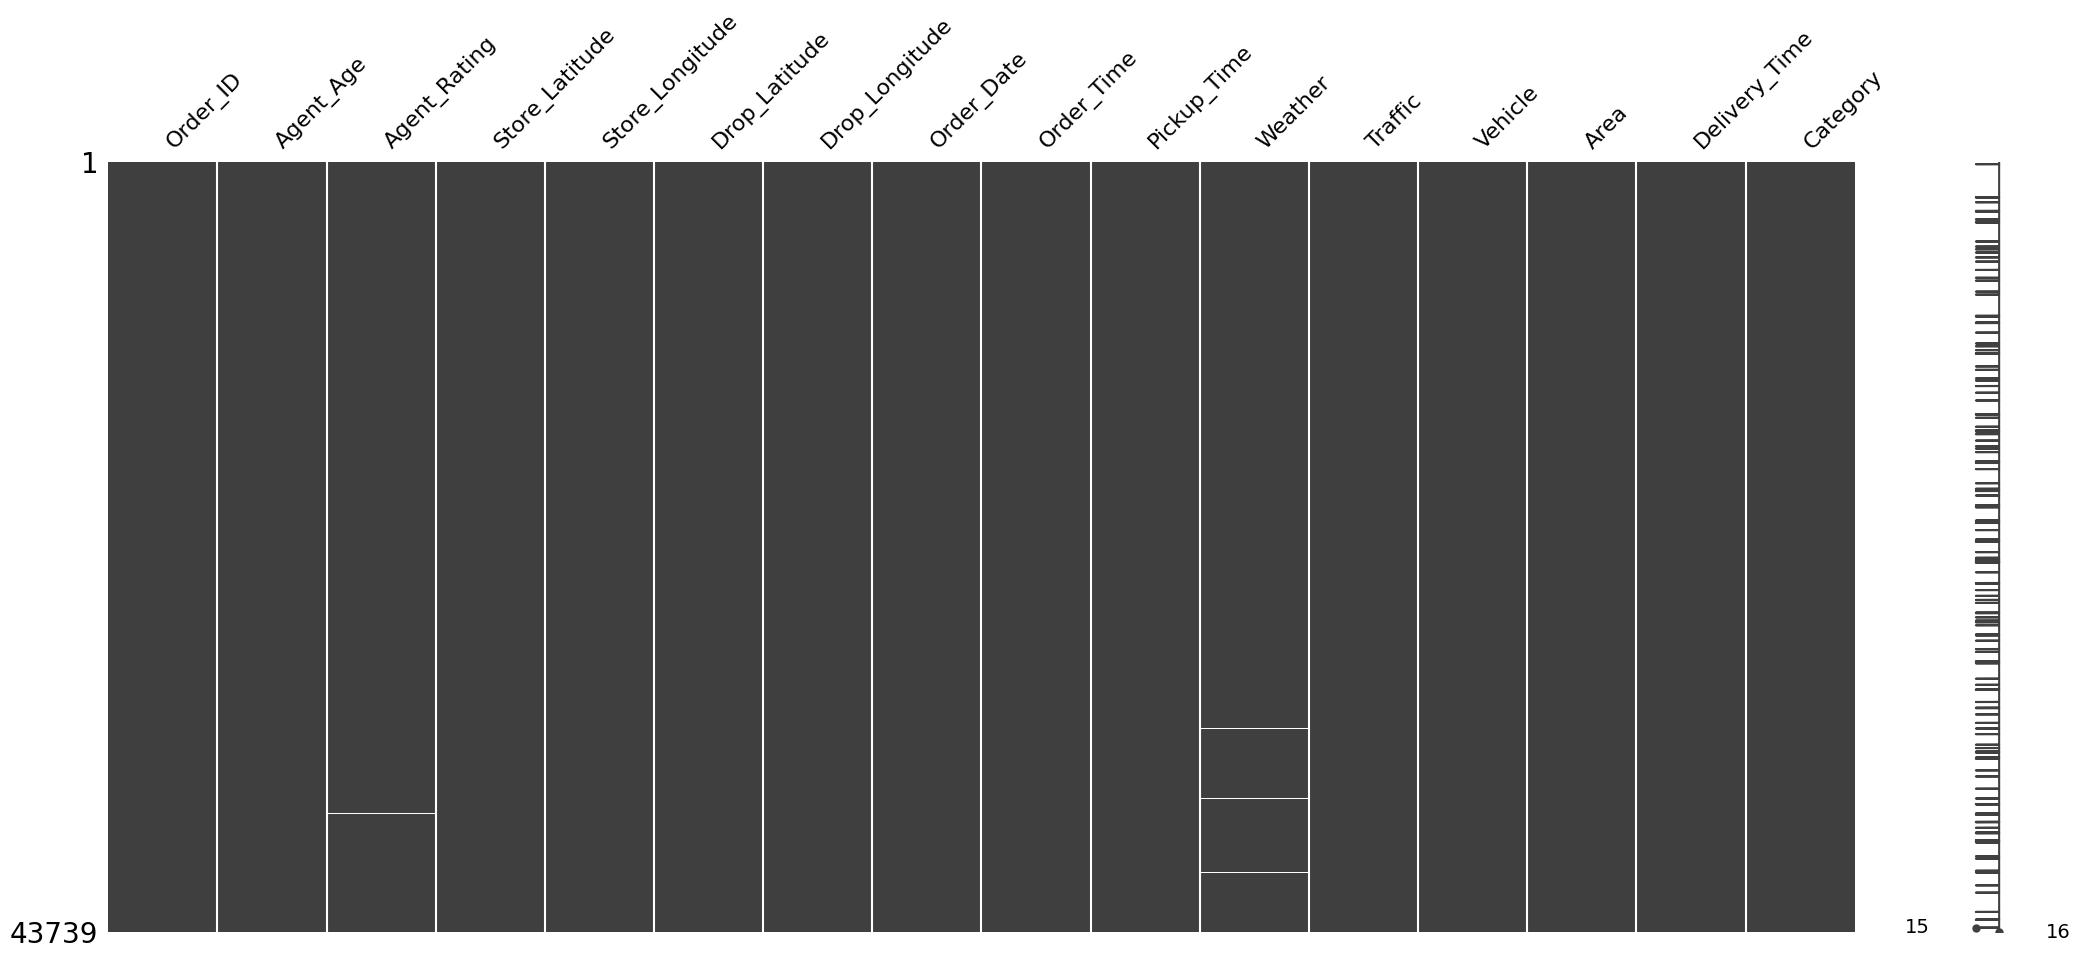

In [7]:
# Missing values percentage
missing_pct = (df.isna().mean() * 100).round(2)
print(missing_pct)

# Visualize missing
display(msno.matrix(df))

# Identify duplicated row
print(f'\nNumber of duplicated rows: {df.duplicated().sum()}')

The missing data for `Agent_Rating` (0.12%) and `Weather` (0.21%) accounts for less than 1% of the rows. Since this information cannot be inferred from other available columns, the affected rows were removed rather than imputed.

As a general guideline:
* < 1% → Rows can be safely removed.
* 1% – 5% → Still manageable with simple strategies.
* 5% – 15% → Requires more sophisticated handling.
* \> 15% → Can significantly impact analysis and must be treated with extra care.

In [12]:
# Drop rows with missing Agent_Rating (0.12%) and Weather (0.21%) since <1% 
df.dropna(axis=0, inplace=True)

In [13]:
def feature_engineering(df):
    df = df.copy()
    
    # Parse datetime
    df['Order_Date'] = pd.to_datetime(df['Order_Date'], errors="coerce")
    df['Order_Time'] = pd.to_datetime(df['Order_Time'], format="%H:%M:%S", errors="coerce")
    df['Pickup_Time'] = pd.to_datetime(df['Pickup_Time'], format="%H:%M:%S", errors="coerce")
    
    # Extract features
    df['order_hour'] = df['Order_Time'].dt.hour
    df['pickup_hour'] = df['Pickup_Time'].dt.hour
    df['order_dayofweek'] = df['Order_Date'].dt.dayofweek
    df['order_month'] = df['Order_Date'].dt.month
    df['pickup_duration_min'] = (df['Pickup_Time'] - df['Order_Time']).dt.total_seconds() / 60
    
    # Haversine distance
    def haversine(lat1, lon1, lat2, lon2):
        R = 6371
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
        c = 2*np.arcsin(np.sqrt(a))
        return R * c
    
    df['store_drop_distance_km'] = haversine(
        df['Store_Latitude'], df['Store_Longitude'],
        df['Drop_Latitude'], df['Drop_Longitude']
    )
    
    return df.drop(columns=[
        'Order_Date','Order_Time','Pickup_Time'
    ])

feat_transformer = FunctionTransformer(feature_engineering)

The `Order_Date`, `Order_Time`, and `Pickup_Time` columns were dropped because they are high-cardinality timestamp fields that do not directly provide predictive power. Instead, their relevant information has been captured through derived features such as `order_hour`, `pickup_hour`, `day_of_week`, `order_month` and `pickup_duration_min`. Removing these raw datetime columns reduces redundancy, prevents data leakage, and ensures the model focuses on meaningful temporal patterns. 

## Outlier detection

In [14]:
df2 = feature_engineering(df)

df2.sample(2)

,Order_ID,Agent_Age,Agent_Rating,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,Weather,Traffic,Vehicle,Area,Delivery_Time,Category,order_hour,pickup_hour,order_dayofweek,order_month,pickup_duration_min,store_drop_distance_km
22393,phiu856545125,33,4.8,17.422819,78.449578,17.462819,78.489578,Sunny,Medium,motorcycle,Metropolitian,110,Sports,15,15,2,3,10.0,6.147215
39126,qefh529659626,24,4.8,26.911927,75.797282,27.021927,75.907282,Windy,Jam,motorcycle,Metropolitian,130,Shoes,19,19,4,3,15.0,16.384467


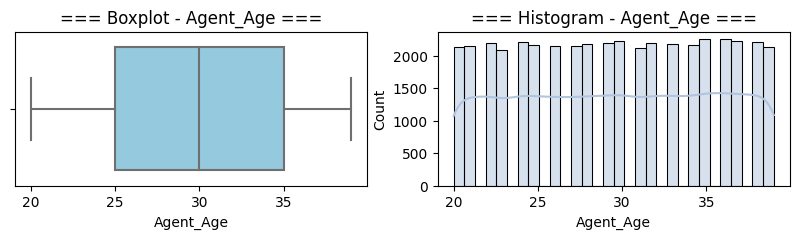

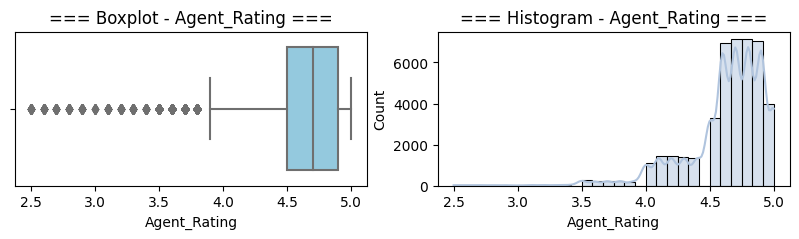

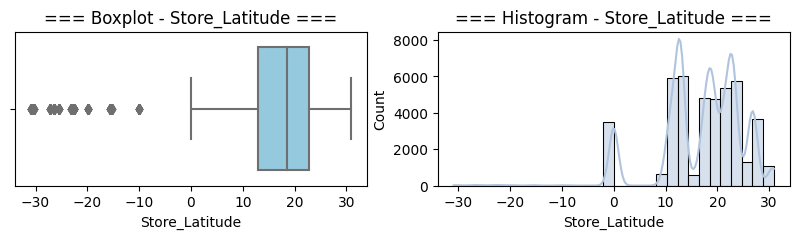

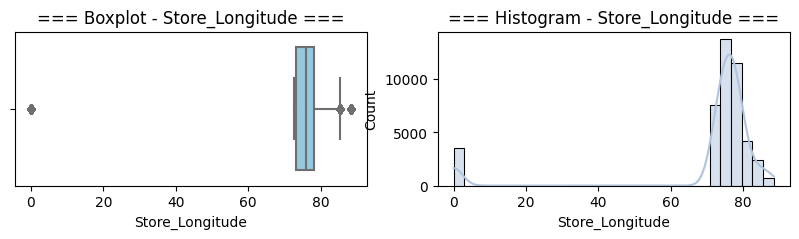

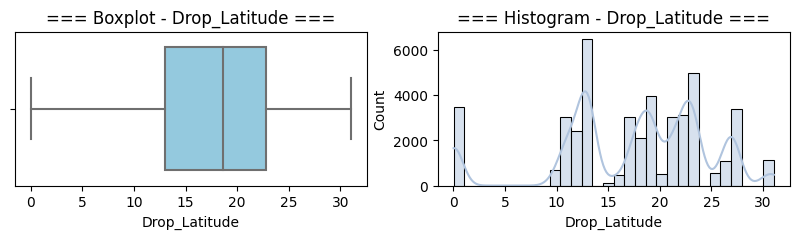

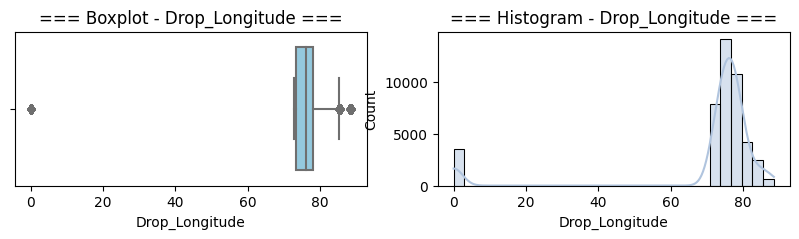

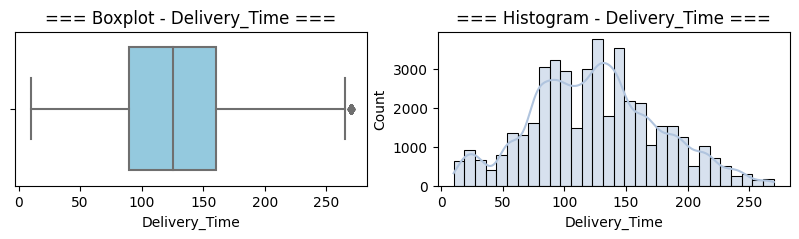

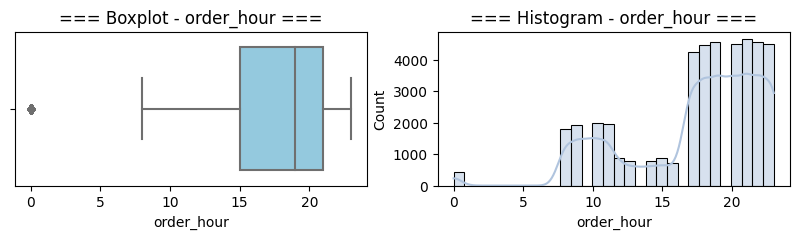

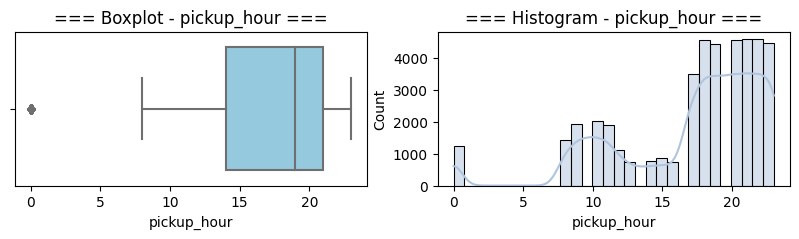

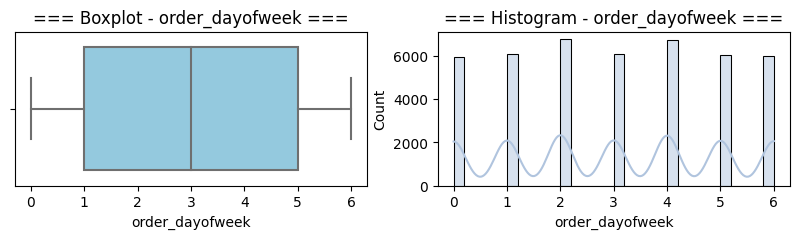

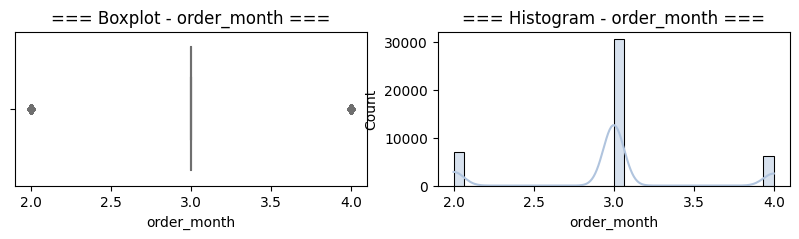

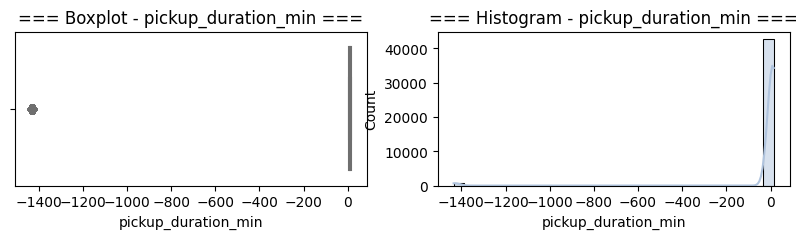

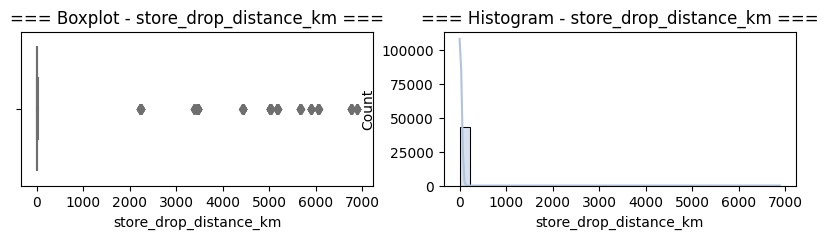


=== Target Variable Check ===
Target 'Delivery_Time' has 79 outliers

=== Outlier Summary Table ===
                        num_outliers  percent_outliers  lower_bound  \
Agent_Age                        0.0          0.000000    10.000000   
Agent_Rating                  1132.0          2.596688     3.900000   
Store_Latitude                 151.0          0.346378    -1.765092   
Store_Longitude               4301.0          9.866037    65.857669   
Drop_Latitude                    0.0          0.000000    -1.712438   
Drop_Longitude                6468.0         14.836904    66.046536   
Delivery_Time                   79.0          0.181218   -15.000000   
order_hour                     429.0          0.984080     6.000000   
pickup_hour                   1254.0          2.876543     3.500000   
order_dayofweek                  0.0          0.000000    -5.000000   
order_month                  13006.0         29.834381     3.000000   
pickup_duration_min            825.0          1

In [15]:
def detect_outliers_iqr(series, multiplier=1.5):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return outliers, lower_bound, upper_bound


def plot_outliers(series, name):
    fig, axes = plt.subplots(1, 2, figsize=(10, 2))
    sns.boxplot(x=series, ax=axes[0], color='skyblue')
    axes[0].set_title(f"=== Boxplot - {name} ===")

    sns.histplot(series, bins=30, kde=True, ax=axes[1], color='lightsteelblue')
    axes[1].set_title(f"=== Histogram - {name} ===")

    plt.show()


def check_outliers(df, target_col=None):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    results = {}

    for col in numeric_cols:
        series = df[col].dropna()
        outliers, lower, upper = detect_outliers_iqr(series)

        results[col] = {
            'num_outliers': len(outliers),
            'percent_outliers': 100 * len(outliers) / len(series),
            'lower_bound': lower,
            'upper_bound': upper
        }

        plot_outliers(series, col)

    if target_col:
        print('\n=== Target Variable Check ===')
        if target_col in results:
            print(f"Target '{target_col}' has {results[target_col]['num_outliers']} outliers")
        else:
            print(f"⚠️ Target column '{target_col}' is not numeric")

    return pd.DataFrame(results).T


outlier_summary = check_outliers(df2, target_col='Delivery_Time')

# Show summary table
print('\n=== Outlier Summary Table ===')
print(outlier_summary)

## Multicollinearity check

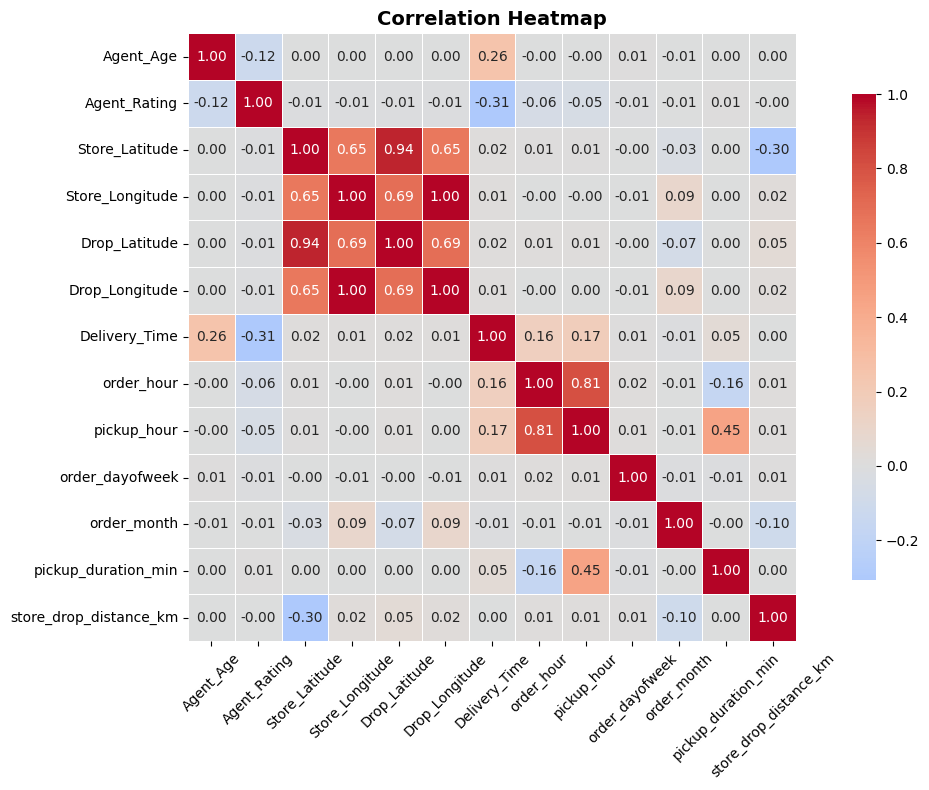

In [18]:
# Lọc các cột số
numeric_cols = df2.select_dtypes(include=np.number).columns

# Vẽ heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    df2[numeric_cols].corr(),
    annot=True,
    cmap='coolwarm',   # bảng màu tương phản rõ
    center=0,          # trung tâm ở 0 để phân biệt âm/dương
    square=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'shrink': 0.8}
)
plt.title("Correlation Heatmap", fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Based on the correlation heatmap, `Drop_Latitude`, `Drop_Longitude`, `Store_Latitude`, and `Store_Longitude` all show at least a strong positive correlation (>0.60) with each other. Since `store_drop_distance_km` was specifically created to capture the distance between a store and a drop point, these latitude and longitude variables can be dropped before model building. Additionally, `order_hour` and `pickup_hour` have a very strong positive correlation (0.81), so `pickup_hour` can also be dropped.

# 2. Model Building
## Preprocessing Pipeline

Although tree-based models such as Random Forest and XGBoost are insensitive to outliers, deep learning models (TensorFlow and PyTorch) will also be used for model comparison. Therefore, a preprocessor with mixed scalers (StandardScaler and RobustScaler) is applied to numerical variables with and without outliers.

In [19]:
# Set a global seed to obtain stable results
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Feature selection
# Define feature groups (after feature_engineering, EDA, outlier, multicollinearity check)
num_features_standard = ['Agent_Age', 'order_hour', 'order_dayofweek', 'order_month']
num_features_robust = ['Agent_Rating', 'pickup_duration_min', 'store_drop_distance_km'] 
cat_features = ['Traffic','Weather','Vehicle','Area','Category']

# Preprocessor with mixed scalers
preprocessor = ColumnTransformer([
    ('num_standard', StandardScaler(), num_features_standard),
    ('num_robust', RobustScaler(), num_features_robust),
    ('cat', OneHotEncoder(handle_unknown="ignore"), cat_features)
])

# Train/test split
target = 'Delivery_Time'
X = df.drop(columns=[target, 'Order_ID'])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

## Model Comparison
### Random Forest Regression (Baseline)

In [20]:
rf_pipeline = Pipeline([
    ('features', feat_transformer),
    ('preprocess', preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=200,
        min_samples_split=15,
        min_samples_leaf=10,
        random_state=seed,
        n_jobs=-1
    ))
])

# Train
rf_pipeline.fit(X_train, y_train)

# Predictions
rf_preds = rf_pipeline.predict(X_test)

# Metrics
rf_mae = mean_absolute_error(y_test, rf_preds)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
rf_r2 = r2_score(y_test, rf_preds)
print(f"RF → MAE: {rf_mae:.3f}, RMSE: {rf_rmse:.3f}, R²: {rf_r2:.2f}")

# Learning curve
train_sizes, train_scores, val_scores = learning_curve(
    rf_pipeline, X_train, y_train,
    cv=3,
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 8),
    n_jobs=-1
)
train_mse_rf = -np.mean(train_scores, axis=1)
val_mse_rf = -np.mean(val_scores, axis=1)

RF → MAE: 17.053, RMSE: 22.099, R²: 0.81


In [21]:
xgb_pipeline = Pipeline([
    ('features', feat_transformer),
    ('preprocess', preprocessor),
    ('model', XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=seed,
        n_jobs=-1
    ))
])

# Train 
xgb_pipeline.fit(X_train, y_train)

# Predictions
xgb_preds = xgb_pipeline.predict(X_test)

# Metrics
xgb_mae = mean_absolute_error(y_test, xgb_preds)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
xgb_r2 = r2_score(y_test, xgb_preds)
print(f"XGB → MAE: {xgb_mae:.3f}, RMSE: {xgb_rmse:.3f}, R²: {xgb_r2:.2f}")

# Learning curve
train_sizes, train_scores, val_scores = learning_curve(
    xgb_pipeline, X_train, y_train,
    cv=3,
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 8),
    n_jobs=-1
)
train_mse_xgb = -np.mean(train_scores, axis=1)
val_mse_xgb = -np.mean(val_scores, axis=1)

XGB → MAE: 17.316, RMSE: 22.301, R²: 0.81


### Data Preparation for Deep Learning

In [23]:
X_train_dl = preprocessor.fit_transform(feature_engineering(X_train))
X_test_dl = preprocessor.transform(feature_engineering(X_test))

X_train_dl = X_train_dl.toarray() if hasattr(X_train_dl, 'toarray') else X_train_dl
X_test_dl = X_test_dl.toarray() if hasattr(X_test_dl, 'toarray') else X_test_dl

y_train_dl, y_test_dl = y_train.values, y_test.values

### TensorFlow DNN 

In [24]:
tf_model = keras.Sequential([
    keras.layers.Input(shape=(X_train_dl.shape[1],)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    
    keras.layers.Dense(64, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)   # regression output
])

tf_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                 loss='mse',
                 metrics=['mae']
                )

# Callbacks
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Train
history_tf = tf_model.fit(
    X_train_dl, y_train_dl,
    validation_data=(X_test_dl, y_test_dl),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Predictions
tf_preds = tf_model.predict(X_test_dl).flatten()

# Metrics
tf_mae = mean_absolute_error(y_test_dl, tf_preds)
tf_rmse = np.sqrt(mean_squared_error(y_test_dl, tf_preds))
tf_r2 = r2_score(y_test_dl, tf_preds)
print(f"TensorFlow DNN → MAE: {tf_mae:.3f}, RMSE: {tf_rmse:.3f}, R²: {tf_r2:.2f}")

# Learning curve
train_mse_tf = history_tf.history['loss']
val_mse_tf = history_tf.history['val_loss']

I0000 00:00:1762237474.597050      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762237474.597701      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/100


I0000 00:00:1762237478.490315     642 service.cc:148] XLA service 0x7a38d800e8c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762237478.490375     642 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762237478.490380     642 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762237478.758503     642 cuda_dnn.cc:529] Loaded cuDNN version 90300


 67/545 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 17575.1035 - mae: 121.9772

I0000 00:00:1762237480.610459     642 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


545/545 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 11000.6885 - mae: 88.5956 - val_loss: 1136.0531 - val_mae: 26.3737 - learning_rate: 0.0010
Epoch 2/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1285.6671 - mae: 28.2187 - val_loss: 971.2870 - val_mae: 24.0768 - learning_rate: 0.0010
Epoch 3/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1138.1664 - mae: 26.4454 - val_loss: 864.2959 - val_mae: 22.7130 - learning_rate: 0.0010
Epoch 4/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1059.7843 - mae: 25.4574 - val_loss: 822.6116 - val_mae: 22.0754 - learning_rate: 0.0010
Epoch 5/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1017.6094 - mae: 24.8418 - val_loss: 800.2742 - val_mae: 21.8024 - learning_rate: 0.0010
Epoch 6/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 977.9492 - mae: 24.3695 - val_loss: 803.4487 - val_mae: 21.7908 - learning_rate: 0.0010
Epoch 7/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 945.2612 - mae: 23.9737 - val_loss: 770.5051 - val

### PyTorch DNN

In [25]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split

# Convert to Torch tensors
X_train_t = torch.tensor(X_train_dl, dtype=torch.float32)
y_train_t = torch.tensor(y_train_dl, dtype=torch.float32)

# Validation split (e.g. 80% train, 20% val)
val_ratio = 0.2
val_size = int(len(X_train_t) * val_ratio)
train_size = len(X_train_t) - val_size

train_ds, val_ds = random_split(
    TensorDataset(X_train_t, y_train_t),
    [train_size, val_size],
    generator=torch.Generator().manual_seed(seed)  # reproducibility
)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)
test_loader = DataLoader(
    TensorDataset(torch.tensor(X_test_dl, dtype=torch.float32),
                  torch.tensor(y_test_dl, dtype=torch.float32)),
    batch_size=32
)

# Model definition
class DeliveryTimeModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x): return self.fc(x)

pt_model = DeliveryTimeModel(X_train_dl.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(pt_model.parameters(), lr=0.01)

# Training loop with validation
num_epochs = 50
train_mse_pt, val_mse_pt = [], []

for epoch in range(num_epochs):
    # Training
    pt_model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = pt_model(xb).squeeze()
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_mse_pt.append(running_loss / len(train_loader))

    # Validation
    pt_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            preds = pt_model(xb).squeeze()
            loss = criterion(preds, yb)
            val_loss += loss.item()
    val_mse_pt.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train MSE: {train_mse_pt[-1]:.3f} | "
          f"Val MSE: {val_mse_pt[-1]:.3f}")

# Final Evaluation on Test Set
pt_model.eval()
with torch.no_grad():
    pt_preds = pt_model(torch.tensor(X_test_dl, dtype=torch.float32)).squeeze().numpy()

pt_mae = mean_absolute_error(y_test_dl, pt_preds)
pt_rmse = np.sqrt(mean_squared_error(y_test_dl, pt_preds))
pt_r2 = r2_score(y_test_dl, pt_preds)
print(f"PyTorch DNN → MAE: {pt_mae:.3f}, RMSE: {pt_rmse:.3f}, R²: {pt_r2:.2f}")

Epoch 1/50 | Train MSE: 6739.849 | Val MSE: 852.674
Epoch 2/50 | Train MSE: 818.805 | Val MSE: 810.315
Epoch 3/50 | Train MSE: 778.847 | Val MSE: 800.741
Epoch 4/50 | Train MSE: 731.918 | Val MSE: 719.309
Epoch 5/50 | Train MSE: 709.393 | Val MSE: 695.729
Epoch 6/50 | Train MSE: 677.493 | Val MSE: 701.905
Epoch 7/50 | Train MSE: 661.638 | Val MSE: 674.510
Epoch 8/50 | Train MSE: 624.605 | Val MSE: 616.906
Epoch 9/50 | Train MSE: 613.927 | Val MSE: 632.949
Epoch 10/50 | Train MSE: 598.310 | Val MSE: 640.964
Epoch 11/50 | Train MSE: 628.367 | Val MSE: 613.233
Epoch 12/50 | Train MSE: 594.855 | Val MSE: 623.073
Epoch 13/50 | Train MSE: 575.112 | Val MSE: 622.171
Epoch 14/50 | Train MSE: 571.858 | Val MSE: 781.392
Epoch 15/50 | Train MSE: 614.621 | Val MSE: 658.496
Epoch 16/50 | Train MSE: 585.095 | Val MSE: 661.732
Epoch 17/50 | Train MSE: 588.032 | Val MSE: 638.747
Epoch 18/50 | Train MSE: 540.473 | Val MSE: 657.868
Epoch 19/50 | Train MSE: 537.653 | Val MSE: 596.476
Epoch 20/50 | Train 

# 3. Model Evaluation

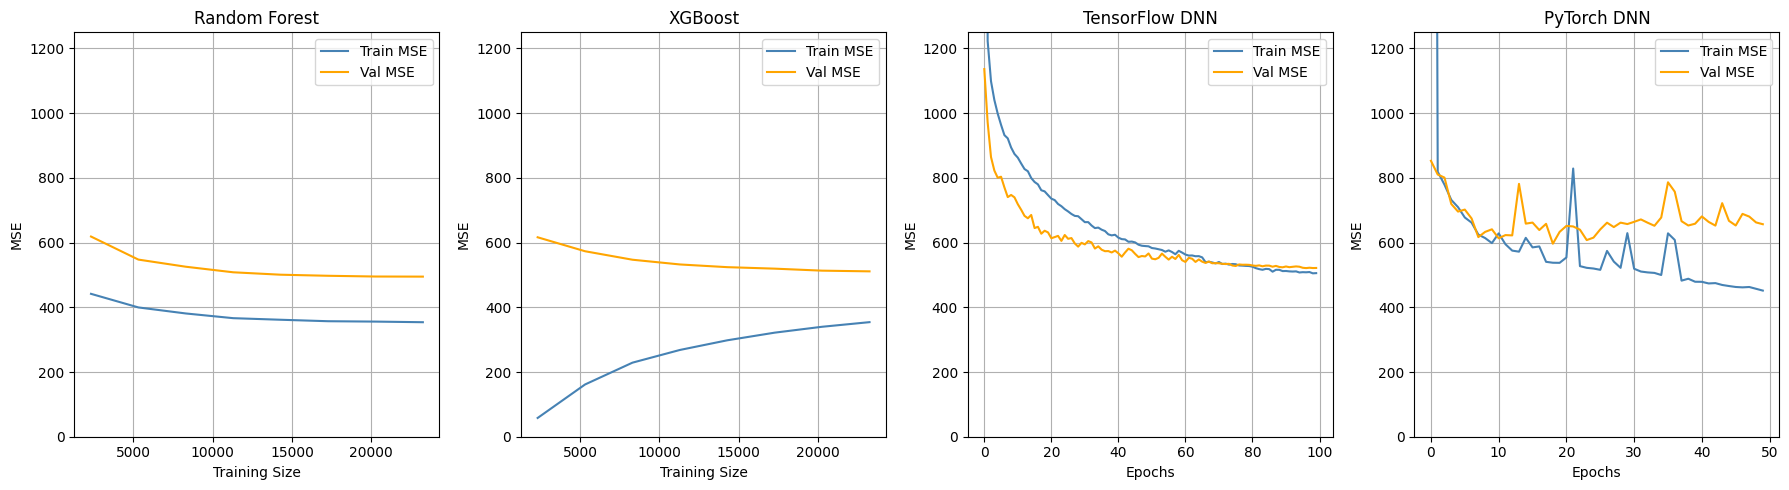

In [26]:
# Diagnose underfitting and overfitting
max_loss_value = max(
    max(val_mse_rf),
    max(val_mse_xgb),
    max(val_mse_tf),
    max(val_mse_pt)
) * 1.1

plt.figure(figsize=(18, 5))

# RF Learning Curve
plt.subplot(1, 4, 1)
plt.plot(train_sizes, train_mse_rf, color='steelblue', label='Train MSE')
plt.plot(train_sizes, val_mse_rf, color='orange', label='Val MSE')
plt.ylim(0, max_loss_value)
plt.title('Random Forest')
plt.xlabel('Training Size')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)

# XGB Learning Curve
plt.subplot(1, 4, 2)
plt.plot(train_sizes, train_mse_xgb, color='steelblue', label='Train MSE')
plt.plot(train_sizes, val_mse_xgb, color='orange', label='Val MSE')
plt.ylim(0, max_loss_value)
plt.title('XGBoost')
plt.xlabel('Training Size')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)

# TensorFlow DNN Learning Curve
plt.subplot(1, 4, 3)
plt.plot(train_mse_tf, color='steelblue', label="Train MSE")
plt.plot(val_mse_tf, color='orange', label="Val MSE")
plt.ylim(0, max_loss_value)
plt.title('TensorFlow DNN')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)

# PyTorch DNN Learning Curve
plt.subplot(1, 4, 4)
plt.plot(train_mse_pt, color='steelblue', label="Train MSE")
plt.plot(val_mse_pt, color='orange', label="Val MSE")
plt.ylim(0, max_loss_value)
plt.title("PyTorch DNN")
plt.xlabel("Epochs")
plt.ylabel('MSE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

* **Random Forest**: The training error remains flat while the validation error is consistently higher, leaving a noticeable gap. This indicates slight underfitting, and increasing the training size does not substantially improve performance since the validation error plateaus early.

* **XGBoost**: The training error rises  with training size, while the validation error steadily decreases and converges closer to training error. This indicates it learns well from larger data and generalizes better than Random Forest in the long run.

* **TensorFlow DNN**: Both train and validation error drop smoothly, and the gap is small. Validation error is consistently close to train error, suggesting strong regularization and stable generalization. The curve shows that the model continues to learn over epochs.

* **PyTorch DNN**: The training error fluctuates, while the validation error diverges as epochs increase. This instability indicates poor convergence and weaker generalization compared to the other models.

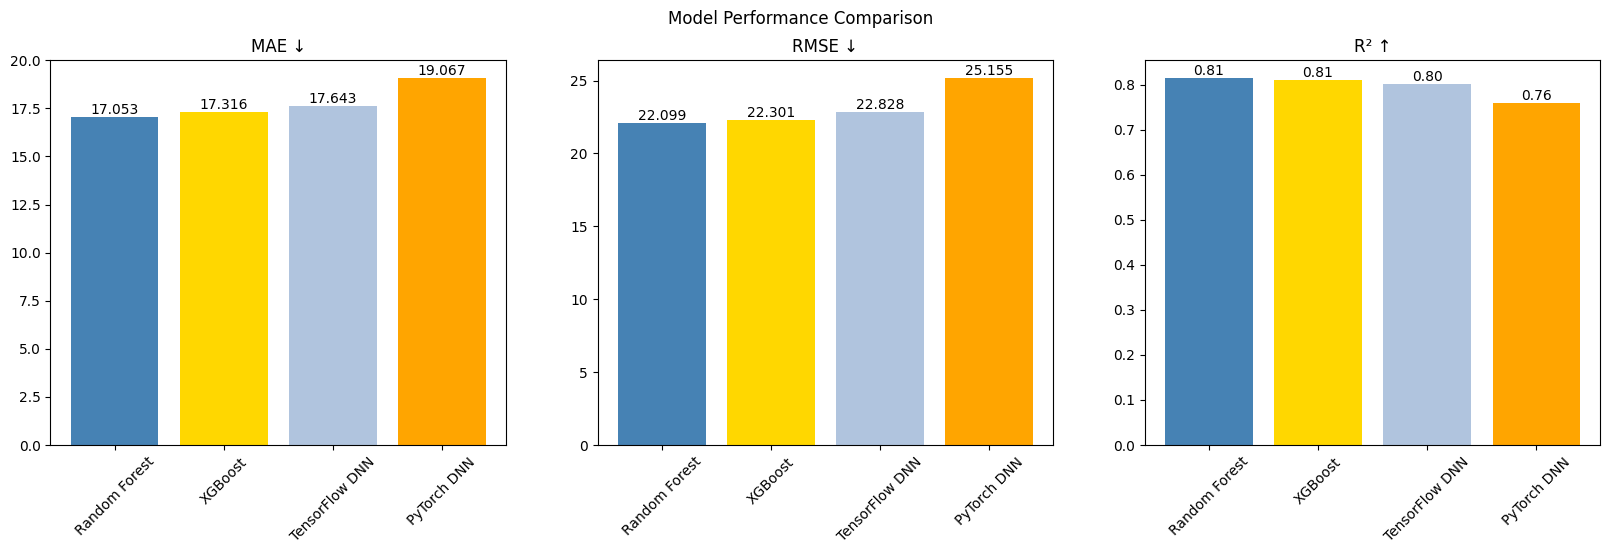

In [27]:
models = ['Random Forest', 'XGBoost', 'TensorFlow DNN', 'PyTorch DNN']
mae_scores = [rf_mae, xgb_mae, tf_mae, pt_mae]
rmse_scores = [rf_rmse, xgb_rmse, tf_rmse, pt_rmse]
r2_scores = [rf_r2, xgb_r2, tf_r2, pt_r2]

fig, axs = plt.subplots(1, 3, figsize=(20, 5))

axs[0].bar(models, mae_scores, color=['steelblue', 'gold', 'lightsteelblue', 'orange'])
for container in axs[0].containers:
    axs[0].bar_label(container, fmt="%.3f")
    axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)
axs[0].set_title('MAE ↓')

axs[1].bar(models, rmse_scores, color=['steelblue', 'gold', 'lightsteelblue', 'orange'])
for container in axs[1].containers:
    axs[1].bar_label(container, fmt="%.3f")
    axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)
axs[1].set_title('RMSE ↓')

axs[2].bar(models, r2_scores, color=['steelblue', 'gold', 'lightsteelblue', 'orange'])
for container in axs[2].containers:
    axs[2].bar_label(container, fmt="%.2f")
    axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=45)
axs[2].set_title('R² ↑')

plt.suptitle('Model Performance Comparison')
plt.show()

Based on the performance metrics, the MAE of **Random Forest (*17.053*)** and **XGBoost (*17.316*)** is slightly lower than that of **TensorFlow DNN (*17.907*)**. Similarly, the RMSE of **Random Forest (*22.099*)** and **XGBoost (*22.301*)** is slightly lower than **TensorFlow DNN (*23.168*)**. The R² of **Random Forest (*0.81*)** and **XGBoost (*0.81*)** is also marginally higher than **TensorFlow DNN (*0.80*)**. Although Random Forest and XGBoost achieve slightly lower error metrics, TensorFlow DNN demonstrates the most stable learning behavior and strong generalization, making it a competitive choice for the parcel delivery time prediction task

# 4. Model Prediction 

In [28]:
joblib.dump(preprocessor, 'preprocessor.pkl')
tf_model.save('delivery_time_model.h5')

print('Preprocessor and model saved!')

Preprocessor and model saved!


In [29]:
# Load preprocessor & model
preprocessor = joblib.load('preprocessor.pkl')
tf_model = keras.models.load_model('delivery_time_model.h5', compile=False)

# Important: recompile for inference
tf_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)


new_order = {
    'Agent_Age': 30,
    'Agent_Rating': 1.0,
    'Order_Date': '2023-12-11',
    'Order_Time': '15:30:00',
    'Pickup_Time': '16:30:00',
    'Traffic': 'High',
    'Weather': 'Sunny',
    'Vehicle': 'van',
    'Area': 'Metropolitian',
    'Category': 'Skincare',
    'Store_Latitude': 3.1390,
    'Store_Longitude': 101.6869,
    'Drop_Latitude': 3.0586,
    'Drop_Longitude': 101.7000
}


# Convert to DataFrame
X_new = pd.DataFrame([new_order])

# Apply feature engineering first (adds order_hour, order_dayofweek, etc.)
X_new_fe = feature_engineering(X_new)

# Apply the SAME preprocessing pipeline
X_new_processed = preprocessor.transform(X_new_fe)

# Predict
pred = tf_model.predict(X_new_processed)[0][0]
print('Predicted delivery time:', round(pred, 2), 'minutes')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
Predicted delivery time: 230.34 minutes
